In [1]:
from tqdm import tqdm
from etnn.nn.baseline import create_baseline_model, calc_params
import pandas as pd
import os
from sklearn.metrics import r2_score
from etnn.tools.training import train_epoch, eval_epoch
from etnn import TreeNode
from etnn.nn.layer_framework import LayerManagementFramework
from etnn.routines.run_config import choice_trainloader, choice_loss, choice_optim
import torch
from torch.utils.data import random_split, DataLoader
from etnn.data.ferris_wheel import load_pure_ferris_wheel_dataset_single_node
from etnn.tools.training_tools import ConfigStore, seeding_all
import matplotlib.pyplot as plt

In [2]:
dataset_path = "../../datasets/"
test_perc = 0.3
stability_count = 5
label = "tree-advanced" # although irrelevant

In [3]:
def create_plot(
        df,
        what: str = "r2"
) -> None:
    plt.figure()

    # Plot the initial data
    for config_id in df.config_id.unique():
        # make subdataset for config id
        sub_df = df[df.config_id == config_id]
        # plot train test and val
        for mode in ['train', 'test', 'val']:
            # plot training
            if f"{mode}_{what}" in sub_df.columns:
                plt.plot(sub_df.epoch, sub_df[f"{mode}_{what}"], label=f"{config_id}_{mode}-{what}")

    plt.title(f"{what} plot")
    plt.xlabel("epoch")
    plt.ylabel("score")
    if what == "r2":
        plt.ylim(-1, +1)
    plt.legend()
    plt.show()

In [4]:
def run(i, entry, size_elem, normalized, node_type, dataset_size):
    # init default config
    config = ConfigStore(
        in_dim=15,
        hidden_dim=int(entry.params_hidden_dim),
        out_dim=1,
        k=1,
        dataset=-1 if normalized else 0,
        ds_size=dataset_size,
        num_gondolas=-1,
        num_part_pg=-1,
        loss_name='mse',
        optimizer_name='adam',
        num_max_epochs=300, # real: 100
        learning_rate=float(entry.params_learning_rate),
        batch_size=1024,
        early_stop_tol=5,
        use_equal_batcher=bool(entry.params_batcher),
        seed=420,
        label_type=label,
        final_label_factor=5/1000
    )

    # loading dataset
    dataset, df_index = load_pure_ferris_wheel_dataset_single_node(
        node_type=node_type,
        num_elem=size_elem,
        num_to_generate=config.ds_size,
        dataset_path=dataset_path,
        final_label_factor=config.final_label_factor,
        normalize=True if config.dataset == -1 else 0
    )

    if post_normalized:
        dataset.post_normalize()

    # splitting off test dataset
    generator = torch.Generator().manual_seed(config.seed)
    train_ds, test_ds= random_split(
        dataset,
        [1 - test_perc, test_perc],
        generator=generator
    )

    # loaders
    train_loader = choice_trainloader(config, df_index, train_ds)
    test_loader = DataLoader(test_ds, batch_size=4 * config.batch_size, shuffle=False)

    # define device
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # set seed for reproducability
    seeding_all(config.seed)

    # define model
    model = LayerManagementFramework(
        in_dim=config.in_dim,
        tree=TreeNode(node_type, [TreeNode("E", size_elem)]),
        hidden_dim=config.hidden_dim,
        out_dim=config.out_dim,
        k=config.k
    ).to(device)
    print(f"Model params etnn: {calc_params(model)}")

    # learning tools
    criterion = choice_loss(config)
    optimizer = choice_optim(config, model)

    # init score list
    train_r2_list = []
    test_r2_list = []
    train_loss_list = []
    test_loss_list = []

    file_name = f"csvs/single-node_node-type-{node_type}_rank-{i}_normalized-{normalized}_post-normalized-{post_normalized}_n-{size_elem}_dataset-size-{dataset_size}.csv"
    if os.path.isfile(file_name):
        df = pd.read_csv(file_name)
    else:
        # train for specified number of epochs
        for epoch in tqdm(range(config.num_max_epochs)):
            train_loss, train_true_y, train_pred_y = train_epoch(
                model,
                train_loader,
                optimizer,
                device,
                criterion
            )

            test_loss, test_true_y, test_pred_y = eval_epoch(
                model,
                test_loader,
                device,
                criterion
            )

            # calc r2 score and append
            train_r2_list += [r2_score(y_true=train_true_y, y_pred=train_pred_y)]
            test_r2_list += [r2_score(y_true=test_true_y, y_pred=test_pred_y)]
            train_loss_list += [train_loss.item()]
            test_loss_list += [test_loss.item()]

        # REPEAT FOR BASELINE MODEL
        seeding_all(config.seed)
        # %%
        model, _ = create_baseline_model(
            n_params=calc_params(model),
            input_dim=config.in_dim * size_elem,
            n_layer=3,
            output_dim=1
        )
        model = model.to(device)

        optimizer = choice_optim(config, model)

        # train for N epochs
        for epoch in tqdm(range(config.num_max_epochs)):
            train_loss, train_true_y, train_pred_y = train_epoch(
                model,
                train_loader,
                optimizer,
                device,
                criterion
            )

            test_loss, test_true_y, test_pred_y = eval_epoch(
                model,
                test_loader,
                device,
                criterion
            )

            # calc r2 score and append
            train_r2_list += [r2_score(y_true=train_true_y, y_pred=train_pred_y)]
            test_r2_list += [r2_score(y_true=test_true_y, y_pred=test_pred_y)]
            train_loss_list += [train_loss.item()]
            test_loss_list += [test_loss.item()]

        df = pd.DataFrame({
            "config_id": ["etnn"]*config.num_max_epochs + ["baseline"]*config.num_max_epochs,
            "epoch": list(range(1, config.num_max_epochs + 1))*2,
            "train_loss": train_loss_list,
            "test_loss": test_loss_list,
            "train_r2": train_r2_list,
            "test_r2": test_r2_list
        })
        df.to_csv(file_name)

    # plotting
    create_plot(df, "r2")
    create_plot(df, "loss")

# Dataset size 10

Rank 1 parameter configuration: Unnamed: 0                                      33
number                                          33
value                                      0.98653
datetime_start          2023-12-21 09:35:04.933499
datetime_complete       2023-12-21 09:35:05.120070
duration                    0 days 00:00:00.186571
params_batcher                                True
params_hidden_dim                               96
params_learning_rate                      0.000015
state                                     COMPLETE
Name: 33, dtype: object
Model params etnn: 26017


100%|██████████| 300/300 [00:01<00:00, 162.65it/s]


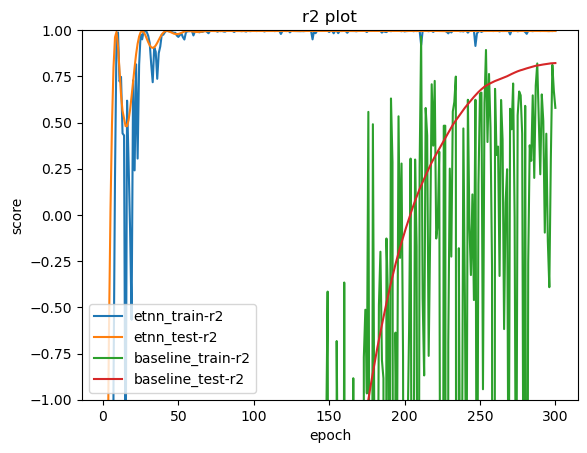

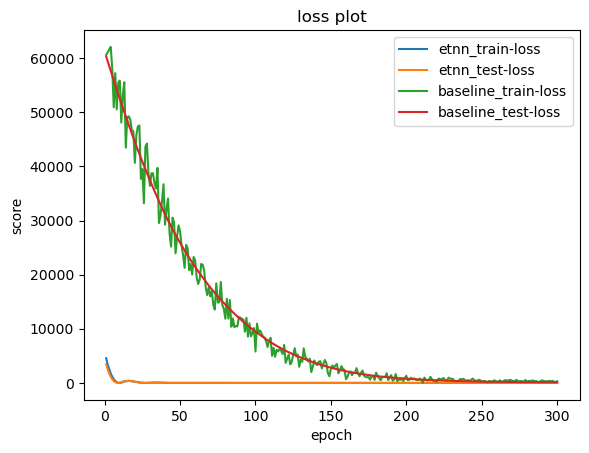

Rank 2 parameter configuration: Unnamed: 0                                      44
number                                          44
value                                     0.980072
datetime_start          2023-12-21 09:35:07.209895
datetime_complete       2023-12-21 09:35:07.431895
duration                    0 days 00:00:00.222000
params_batcher                                True
params_hidden_dim                               96
params_learning_rate                      0.000026
state                                     COMPLETE
Name: 44, dtype: object
Model params etnn: 26017


100%|██████████| 300/300 [00:01<00:00, 151.42it/s]


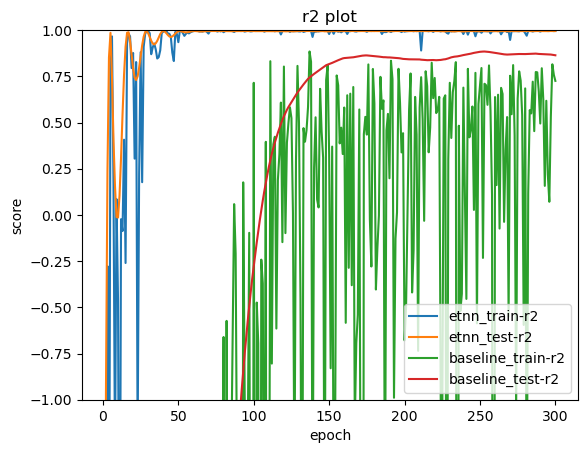

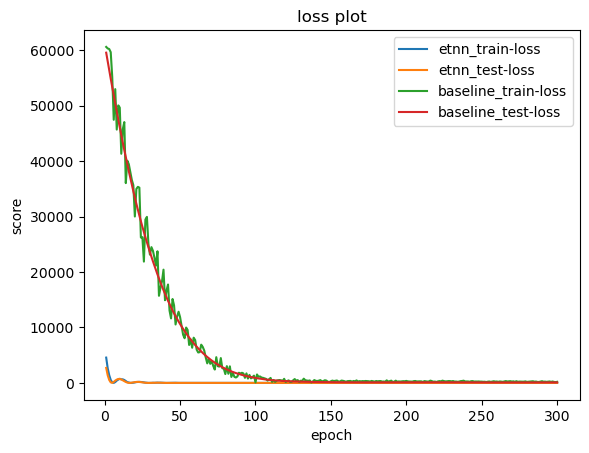

Rank 3 parameter configuration: Unnamed: 0                                      49
number                                          49
value                                     0.979614
datetime_start          2023-12-21 09:35:08.311311
datetime_complete       2023-12-21 09:35:08.533311
duration                    0 days 00:00:00.222000
params_batcher                                True
params_hidden_dim                               96
params_learning_rate                      0.000026
state                                     COMPLETE
Name: 49, dtype: object
Model params etnn: 26017


100%|██████████| 300/300 [00:02<00:00, 145.77it/s]


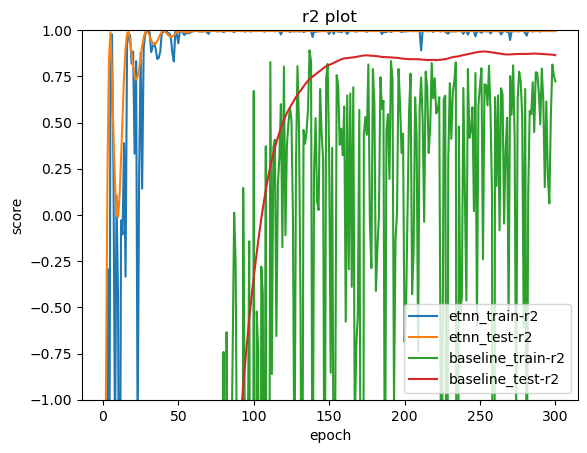

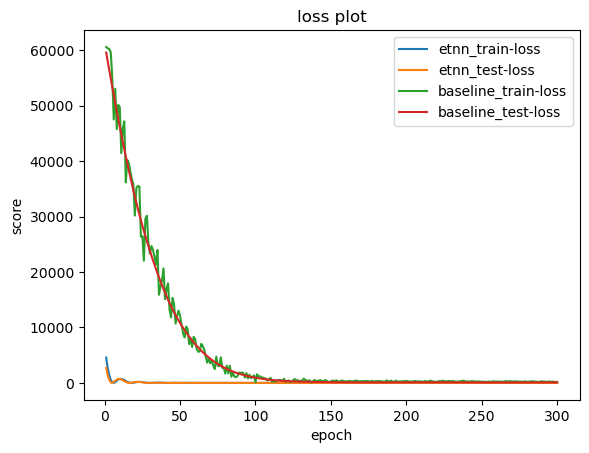

In [5]:
normalized = False
post_normalized = False
size_elem = 10
node_type = "P"
dataset_size = 10

config_table = pd.read_csv(f"csvs/single-node_t-{node_type}_n-{size_elem}_normalized-{normalized}_post-normalized-{post_normalized}_dataset-size-{dataset_size}.csv")

# sort config storage
config_table = config_table.sort_values(by=['value'], ascending=False)

# iterate over top 3 best configs
for i in range(3):
    # get entry from dataframe
    entry = config_table.iloc[i]

    # print information to console
    print(f"Rank {i+1} parameter configuration: {entry}")

    run(i, entry, size_elem, normalized, node_type, dataset_size)

Rank 1 parameter configuration: Unnamed: 0                                     155
number                                         155
value                                    -3.732487
datetime_start          2023-12-21 09:35:44.986069
datetime_complete       2023-12-21 09:35:45.194069
duration                    0 days 00:00:00.208000
params_batcher                                True
params_hidden_dim                              416
params_learning_rate                      0.004728
state                                     COMPLETE
Name: 155, dtype: object
Model params etnn: 462177


100%|██████████| 300/300 [00:01<00:00, 154.92it/s]


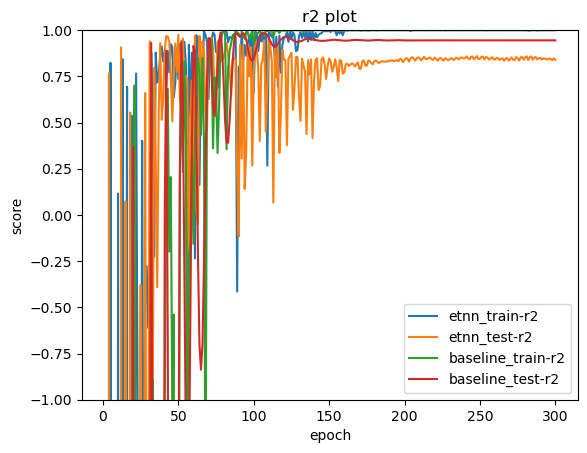

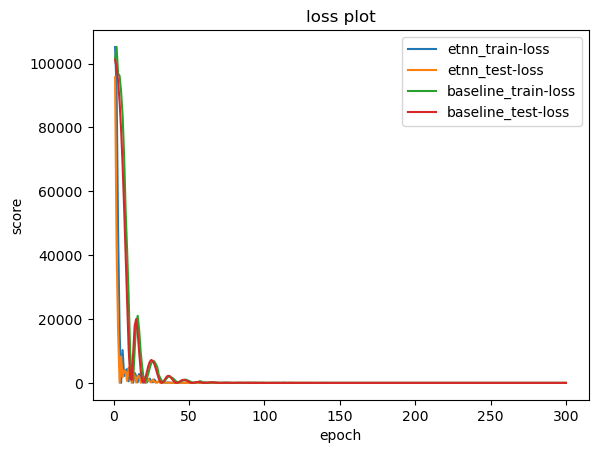

Rank 2 parameter configuration: Unnamed: 0                                      65
number                                          65
value                                    -4.104499
datetime_start          2023-12-21 09:35:25.872791
datetime_complete       2023-12-21 09:35:26.081791
duration                    0 days 00:00:00.209000
params_batcher                                True
params_hidden_dim                              320
params_learning_rate                      0.004816
state                                     COMPLETE
Name: 65, dtype: object
Model params etnn: 274881


100%|██████████| 300/300 [00:02<00:00, 132.89it/s]


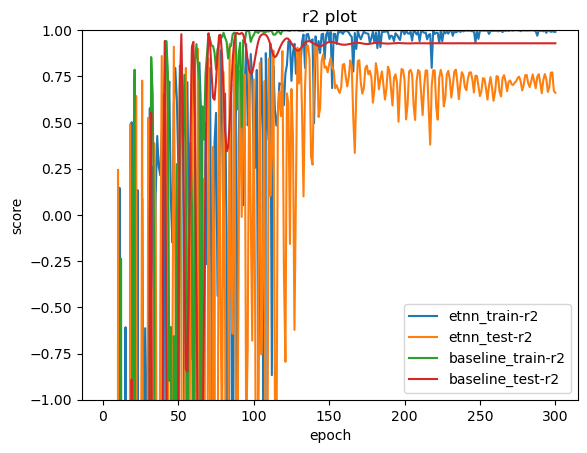

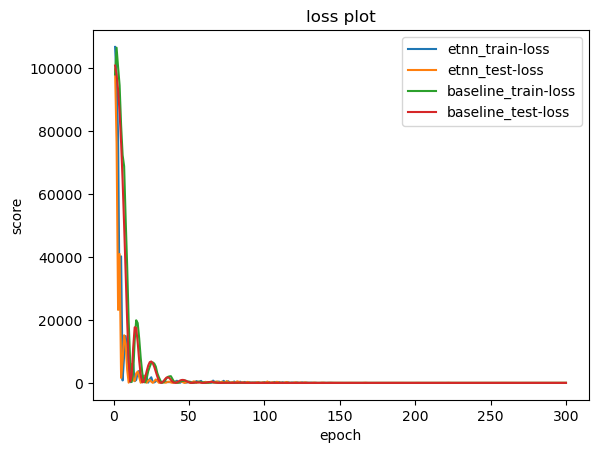

Rank 3 parameter configuration: Unnamed: 0                                      85
number                                          85
value                                    -6.040929
datetime_start          2023-12-21 09:35:30.068874
datetime_complete       2023-12-21 09:35:30.281876
duration                    0 days 00:00:00.213002
params_batcher                               False
params_hidden_dim                              496
params_learning_rate                      0.002824
state                                     COMPLETE
Name: 85, dtype: object
Model params etnn: 655217


100%|██████████| 300/300 [00:02<00:00, 141.35it/s]


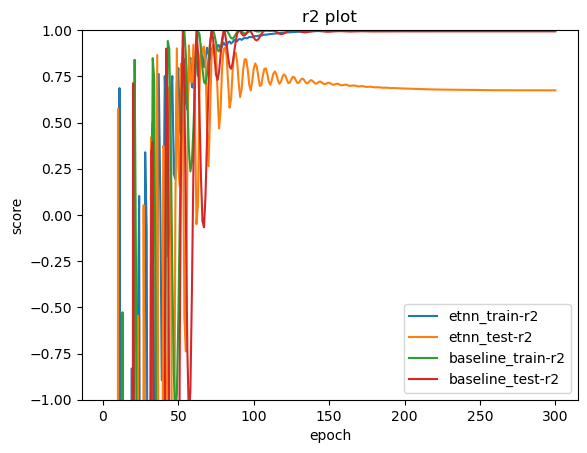

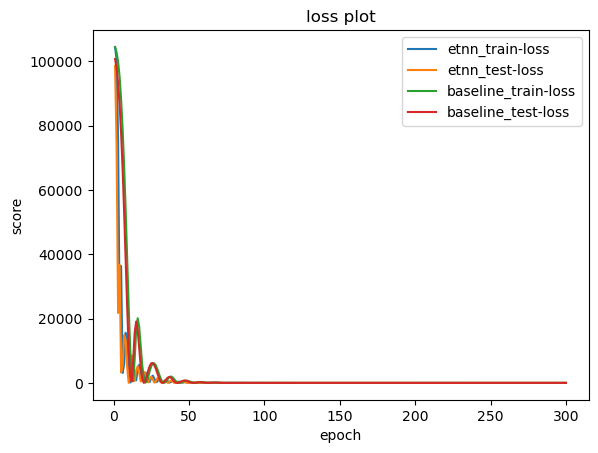

In [6]:
normalized = True
post_normalized = False
size_elem = 10
node_type = "P"
dataset_size = 10

config_table = pd.read_csv(f"csvs/single-node_t-{node_type}_n-{size_elem}_normalized-{normalized}_post-normalized-{post_normalized}_dataset-size-{dataset_size}.csv")

# sort config storage
config_table = config_table.sort_values(by=['value'], ascending=False)

# iterate over top 3 best configs
for i in range(3):
    # get entry from dataframe
    entry = config_table.iloc[i]

    # print information to console
    print(f"Rank {i+1} parameter configuration: {entry}")

    run(i, entry, size_elem, normalized, node_type, dataset_size)

Rank 1 parameter configuration: Unnamed: 0                                     157
number                                         157
value                                     0.051771
datetime_start          2023-12-21 09:36:32.991795
datetime_complete       2023-12-21 09:36:33.190474
duration                    0 days 00:00:00.198679
params_batcher                                True
params_hidden_dim                              272
params_learning_rate                      0.003198
state                                     COMPLETE
Name: 157, dtype: object
Model params etnn: 199377


100%|██████████| 300/300 [00:02<00:00, 126.83it/s]


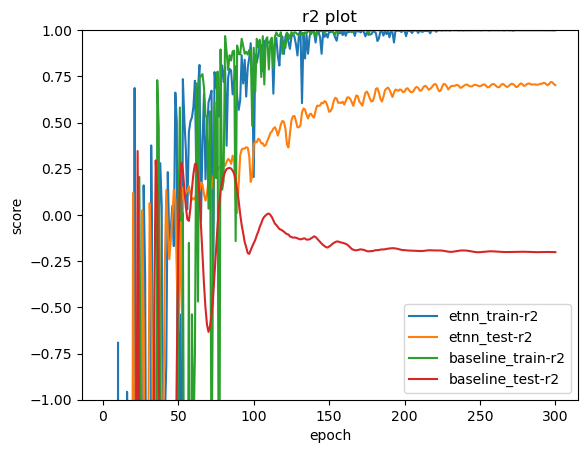

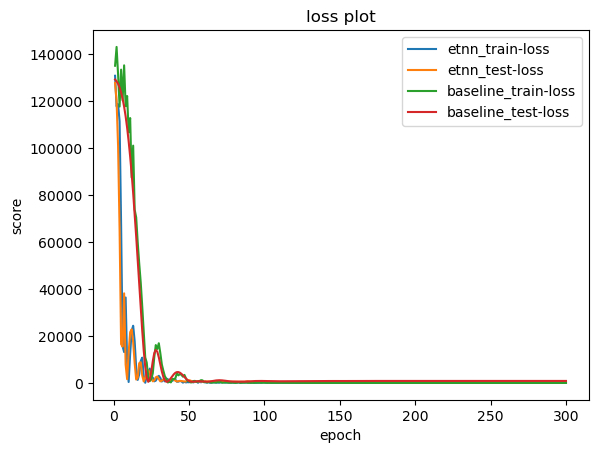

Rank 2 parameter configuration: Unnamed: 0                                     101
number                                         101
value                                    -0.073746
datetime_start          2023-12-21 09:36:20.355112
datetime_complete       2023-12-21 09:36:20.577419
duration                    0 days 00:00:00.222307
params_batcher                               False
params_hidden_dim                              304
params_learning_rate                       0.00315
state                                     COMPLETE
Name: 101, dtype: object
Model params etnn: 248369


100%|██████████| 300/300 [00:02<00:00, 114.07it/s]


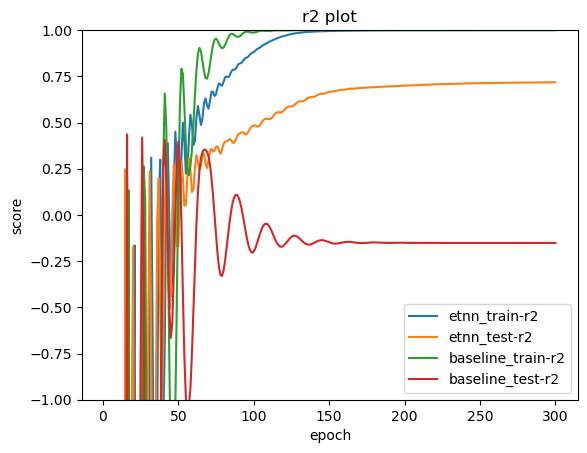

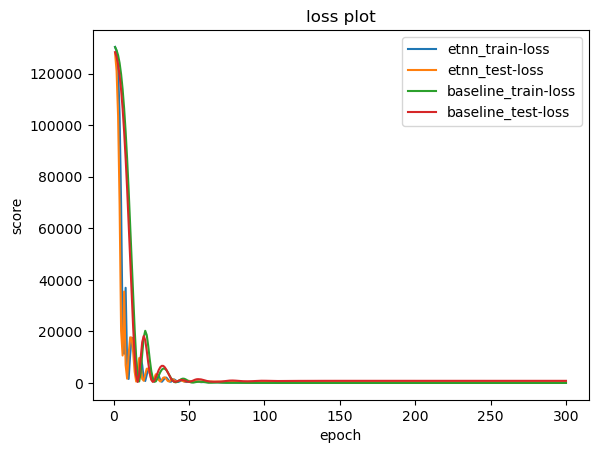

Rank 3 parameter configuration: Unnamed: 0                                     106
number                                         106
value                                    -0.084806
datetime_start          2023-12-21 09:36:21.579418
datetime_complete       2023-12-21 09:36:21.786418
duration                    0 days 00:00:00.207000
params_batcher                               False
params_hidden_dim                              240
params_learning_rate                      0.004276
state                                     COMPLETE
Name: 106, dtype: object
Model params etnn: 155761


100%|██████████| 300/300 [00:02<00:00, 131.38it/s]


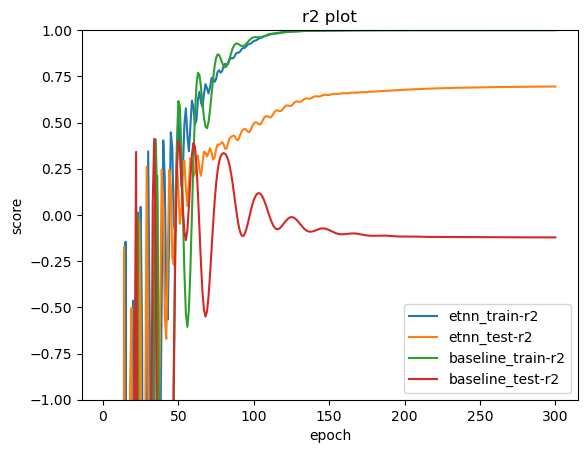

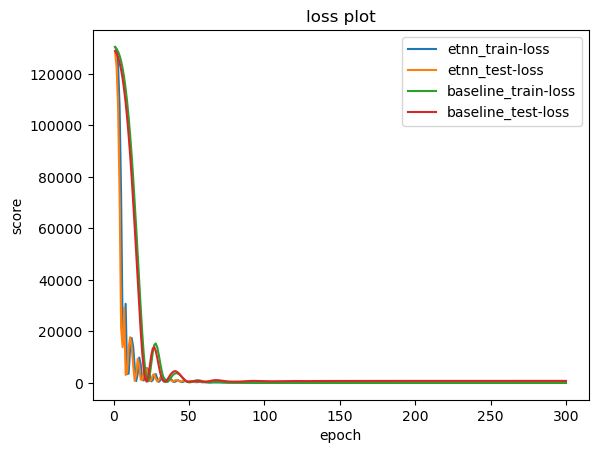

In [7]:
normalized = False
post_normalized = True
size_elem = 10
node_type = "P"
dataset_size = 10

config_table = pd.read_csv(f"csvs/single-node_t-{node_type}_n-{size_elem}_normalized-{normalized}_post-normalized-{post_normalized}_dataset-size-{dataset_size}.csv")

# sort config storage
config_table = config_table.sort_values(by=['value'], ascending=False)

# iterate over top 3 best configs
for i in range(3):
    # get entry from dataframe
    entry = config_table.iloc[i]

    # print information to console
    print(f"Rank {i+1} parameter configuration: {entry}")

    run(i, entry, size_elem, normalized, node_type, dataset_size)

# Dataset size 100

Rank 1 parameter configuration: Unnamed: 0                                      22
number                                          22
value                                     0.936793
datetime_start          2023-12-21 09:47:21.314655
datetime_complete       2023-12-21 09:47:22.162974
duration                    0 days 00:00:00.848319
params_batcher                                True
params_hidden_dim                               96
params_learning_rate                      0.000024
state                                     COMPLETE
Name: 22, dtype: object
Model params etnn: 26017


100%|██████████| 300/300 [00:11<00:00, 26.53it/s]


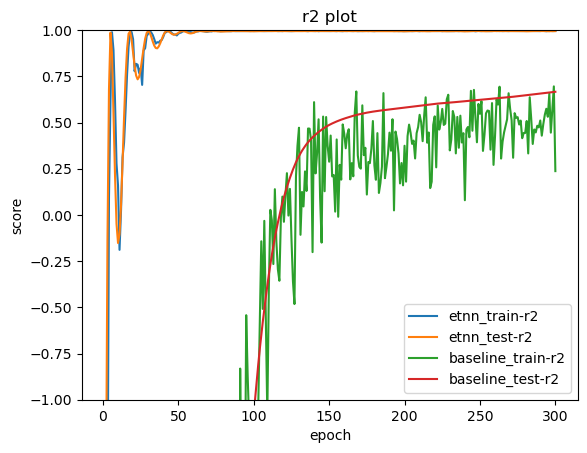

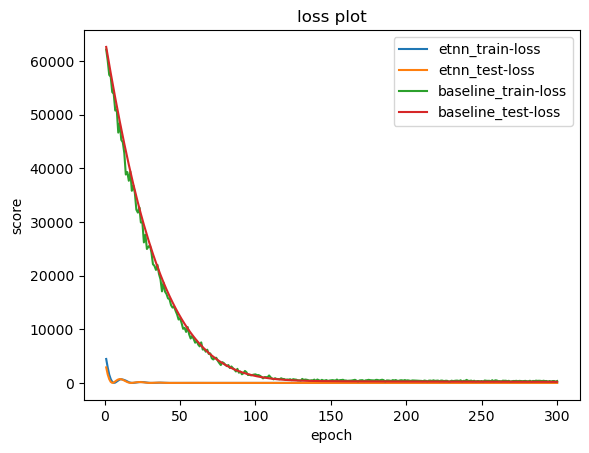

Rank 2 parameter configuration: Unnamed: 0                                      21
number                                          21
value                                     0.927991
datetime_start          2023-12-21 09:47:20.489896
datetime_complete       2023-12-21 09:47:21.313656
duration                    0 days 00:00:00.823760
params_batcher                                True
params_hidden_dim                               96
params_learning_rate                      0.000031
state                                     COMPLETE
Name: 21, dtype: object
Model params etnn: 26017


100%|██████████| 300/300 [00:11<00:00, 25.34it/s]


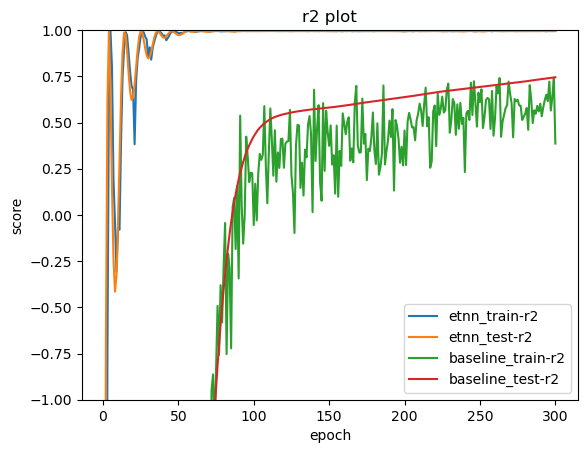

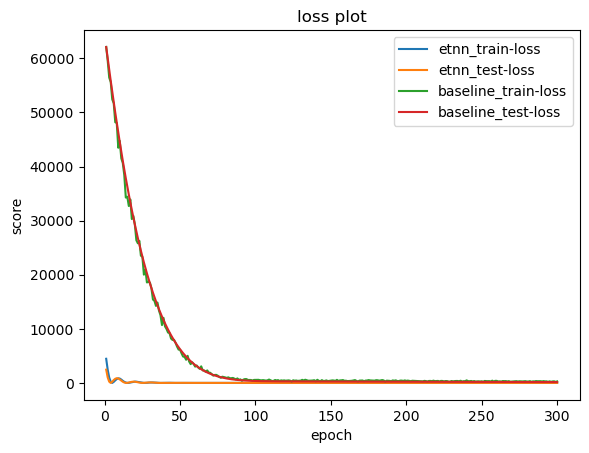

Rank 3 parameter configuration: Unnamed: 0                                      23
number                                          23
value                                     0.917357
datetime_start          2023-12-21 09:47:22.163974
datetime_complete       2023-12-21 09:47:22.996700
duration                    0 days 00:00:00.832726
params_batcher                                True
params_hidden_dim                               96
params_learning_rate                      0.000023
state                                     COMPLETE
Name: 23, dtype: object
Model params etnn: 26017


100%|██████████| 300/300 [00:12<00:00, 24.81it/s]


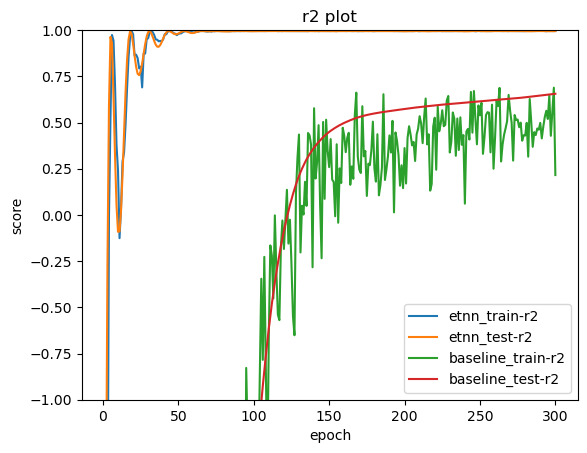

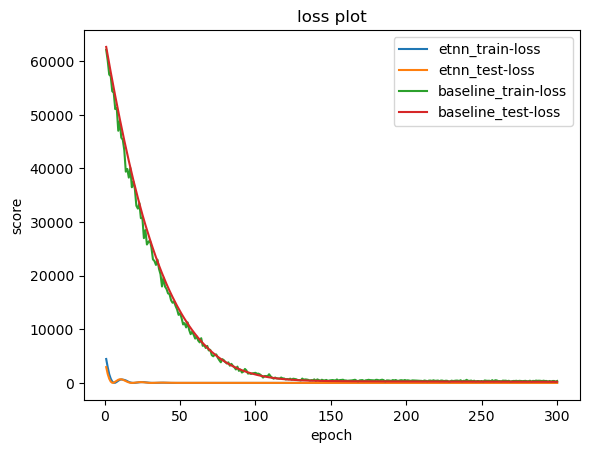

In [8]:
normalized = False
post_normalized = False
size_elem = 10
node_type = "P"
dataset_size = 100

config_table = pd.read_csv(f"csvs/single-node_t-{node_type}_n-{size_elem}_normalized-{normalized}_post-normalized-{post_normalized}_dataset-size-{dataset_size}.csv")

# sort config storage
config_table = config_table.sort_values(by=['value'], ascending=False)

# iterate over top 3 best configs
for i in range(3):
    # get entry from dataframe
    entry = config_table.iloc[i]

    # print information to console
    print(f"Rank {i+1} parameter configuration: {entry}")

    run(i, entry, size_elem, normalized, node_type, dataset_size)

Rank 1 parameter configuration: Unnamed: 0                                     144
number                                         144
value                                      0.63961
datetime_start          2023-12-21 09:49:49.634509
datetime_complete       2023-12-21 09:49:50.494044
duration                    0 days 00:00:00.859535
params_batcher                                True
params_hidden_dim                              352
params_learning_rate                      0.008986
state                                     COMPLETE
Name: 144, dtype: object
Model params etnn: 331937


100%|██████████| 300/300 [00:10<00:00, 29.97it/s]


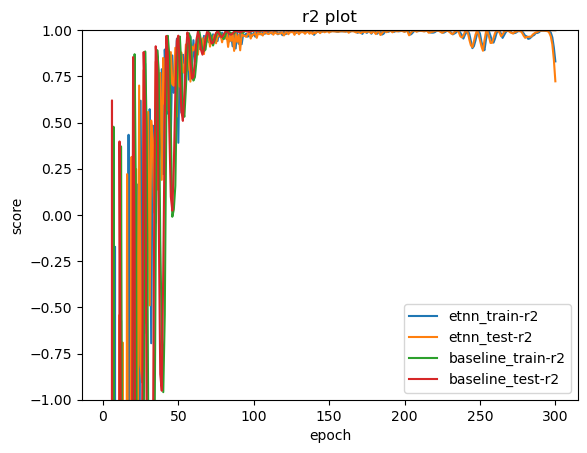

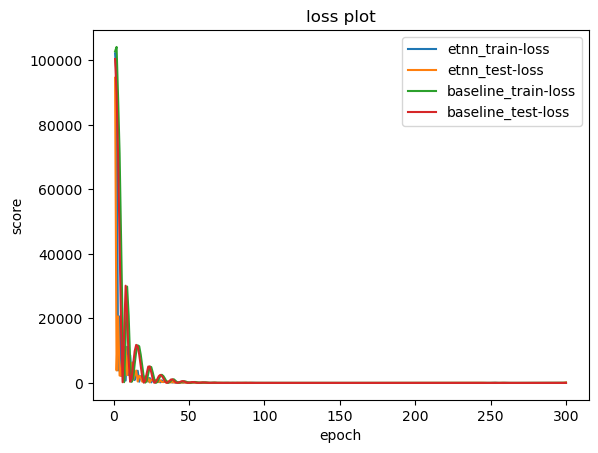

Rank 2 parameter configuration: Unnamed: 0                                     149
number                                         149
value                                     0.518234
datetime_start          2023-12-21 09:49:53.598047
datetime_complete       2023-12-21 09:49:54.347233
duration                    0 days 00:00:00.749186
params_batcher                                True
params_hidden_dim                              448
params_learning_rate                      0.006627
state                                     COMPLETE
Name: 149, dtype: object
Model params etnn: 535361


100%|██████████| 300/300 [00:10<00:00, 29.76it/s]


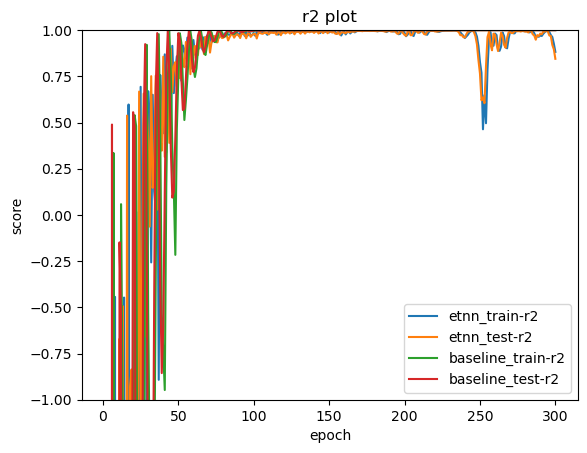

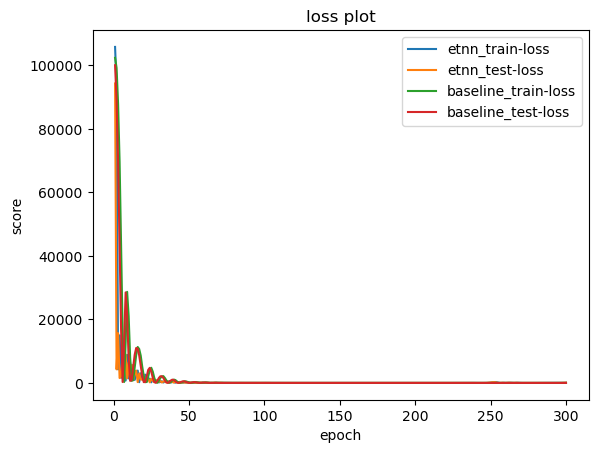

Rank 3 parameter configuration: Unnamed: 0                                     194
number                                         194
value                                     0.490805
datetime_start          2023-12-21 09:50:28.764788
datetime_complete       2023-12-21 09:50:29.466169
duration                    0 days 00:00:00.701381
params_batcher                                True
params_hidden_dim                              240
params_learning_rate                      0.009905
state                                     COMPLETE
Name: 194, dtype: object
Model params etnn: 155761


100%|██████████| 300/300 [00:10<00:00, 29.48it/s]


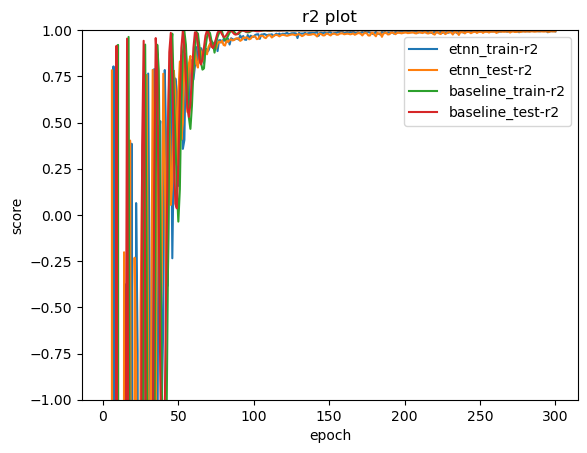

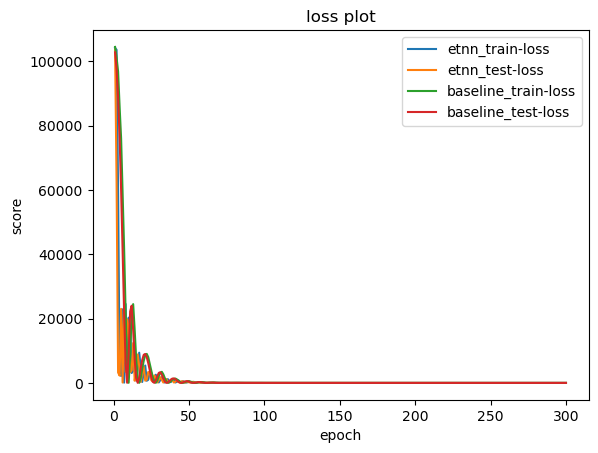

In [9]:
normalized = True
post_normalized = False
size_elem = 10
node_type = "P"
dataset_size = 100

config_table = pd.read_csv(f"csvs/single-node_t-{node_type}_n-{size_elem}_normalized-{normalized}_post-normalized-{post_normalized}_dataset-size-{dataset_size}.csv")

# sort config storage
config_table = config_table.sort_values(by=['value'], ascending=False)

# iterate over top 3 best configs
for i in range(3):
    # get entry from dataframe
    entry = config_table.iloc[i]

    # print information to console
    print(f"Rank {i+1} parameter configuration: {entry}")

    run(i, entry, size_elem, normalized, node_type, dataset_size)

Rank 1 parameter configuration: Unnamed: 0                                      64
number                                          64
value                                     0.568901
datetime_start          2023-12-21 09:54:58.672602
datetime_complete       2023-12-21 09:54:59.781407
duration                    0 days 00:00:01.108805
params_batcher                                True
params_hidden_dim                              512
params_learning_rate                      0.007899
state                                     COMPLETE
Name: 64, dtype: object
Model params etnn: 697857


100%|██████████| 300/300 [00:13<00:00, 22.35it/s]


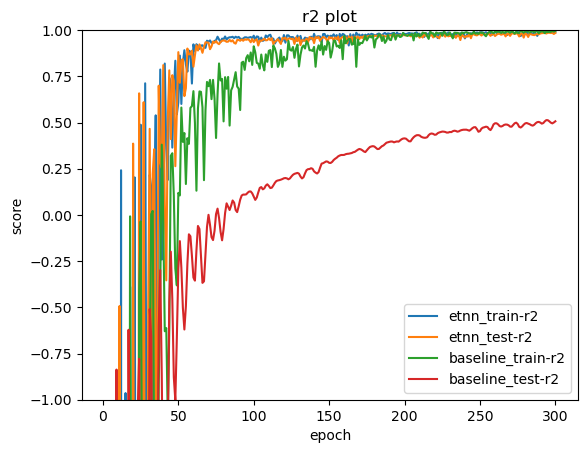

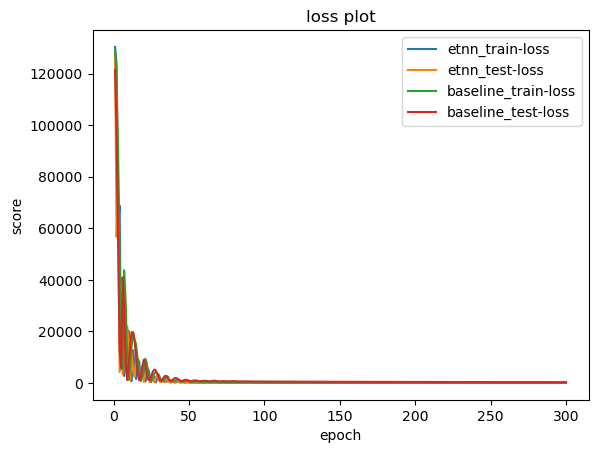

Rank 2 parameter configuration: Unnamed: 0                                     138
number                                         138
value                                     0.116373
datetime_start          2023-12-21 09:56:31.440641
datetime_complete       2023-12-21 09:56:32.755796
duration                    0 days 00:00:01.315155
params_batcher                                True
params_hidden_dim                              432
params_learning_rate                      0.005794
state                                     COMPLETE
Name: 138, dtype: object
Model params etnn: 498097


100%|██████████| 300/300 [00:13<00:00, 22.92it/s]


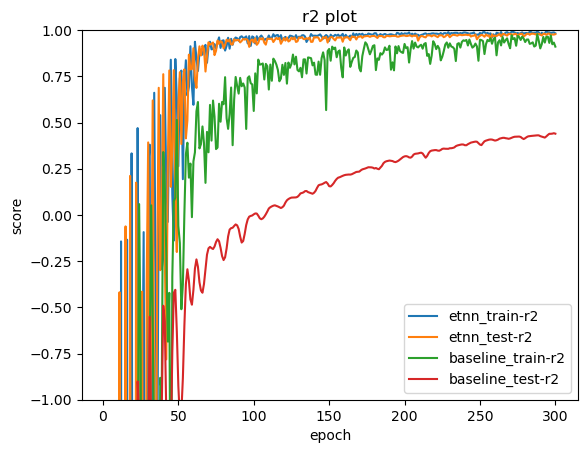

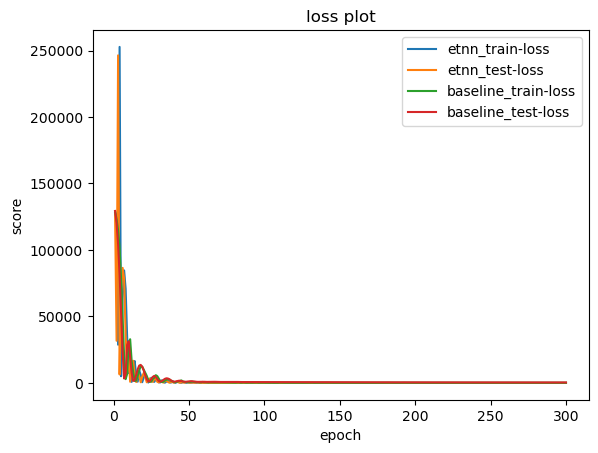

Rank 3 parameter configuration: Unnamed: 0                                     160
number                                         160
value                                      0.08282
datetime_start          2023-12-21 09:56:59.351552
datetime_complete       2023-12-21 09:57:00.675680
duration                    0 days 00:00:01.324128
params_batcher                                True
params_hidden_dim                              496
params_learning_rate                      0.003958
state                                     COMPLETE
Name: 160, dtype: object
Model params etnn: 655217


100%|██████████| 300/300 [00:13<00:00, 22.40it/s]


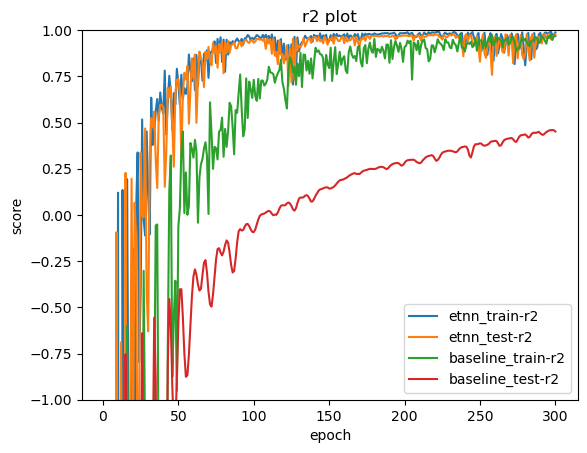

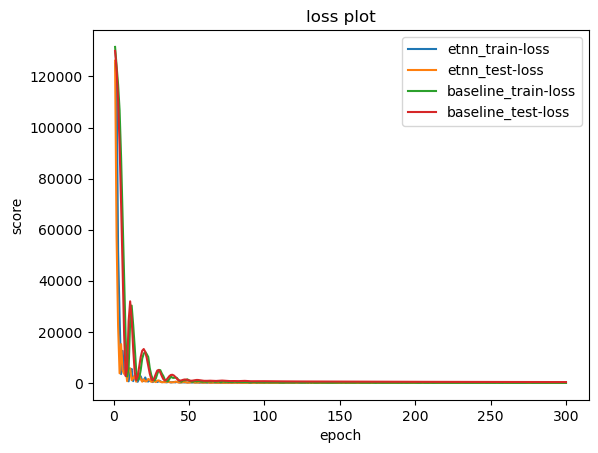

In [10]:
normalized = False
post_normalized = True
size_elem = 10
node_type = "P"
dataset_size = 100

config_table = pd.read_csv(f"csvs/single-node_t-{node_type}_n-{size_elem}_normalized-{normalized}_post-normalized-{post_normalized}_dataset-size-{dataset_size}.csv")

# sort config storage
config_table = config_table.sort_values(by=['value'], ascending=False)

# iterate over top 3 best configs
for i in range(3):
    # get entry from dataframe
    entry = config_table.iloc[i]

    # print information to console
    print(f"Rank {i+1} parameter configuration: {entry}")

    run(i, entry, size_elem, normalized, node_type, dataset_size)

# Dataset size 1000

Rank 1 parameter configuration: Unnamed: 0                                      35
number                                          35
value                                      0.93887
datetime_start          2023-12-21 10:03:18.096253
datetime_complete       2023-12-21 10:03:28.715669
duration                    0 days 00:00:10.619416
params_batcher                                True
params_hidden_dim                              224
params_learning_rate                      0.000023
state                                     COMPLETE
Name: 35, dtype: object
Model params etnn: 135969


100%|██████████| 300/300 [01:40<00:00,  3.00it/s]


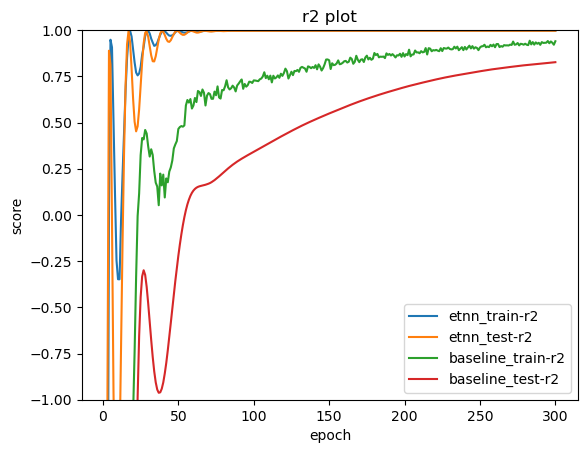

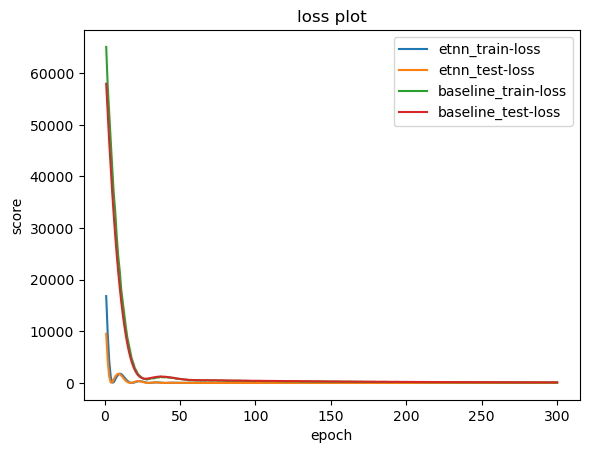

Rank 2 parameter configuration: Unnamed: 0                                      42
number                                          42
value                                     0.930607
datetime_start          2023-12-21 10:04:31.234807
datetime_complete       2023-12-21 10:04:41.555574
duration                    0 days 00:00:10.320767
params_batcher                                True
params_hidden_dim                              224
params_learning_rate                      0.000011
state                                     COMPLETE
Name: 42, dtype: object
Model params etnn: 135969


100%|██████████| 300/300 [02:01<00:00,  2.46it/s]


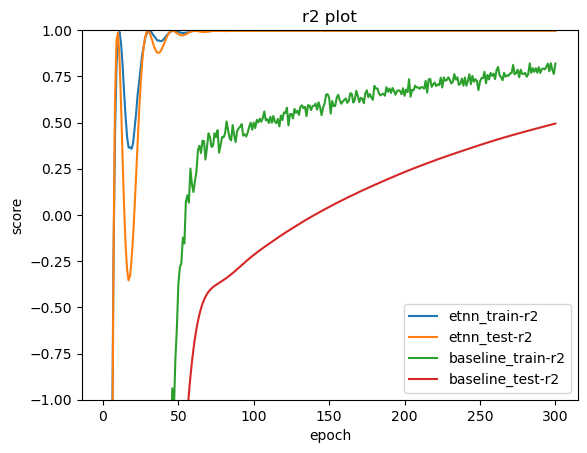

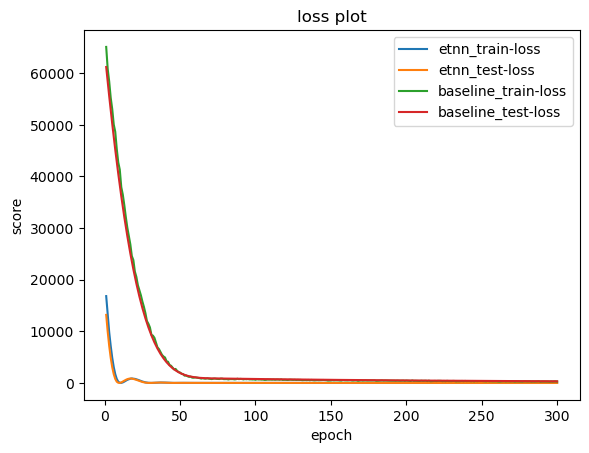

Rank 3 parameter configuration: Unnamed: 0                                      36
number                                          36
value                                     0.927714
datetime_start          2023-12-21 10:03:28.717669
datetime_complete       2023-12-21 10:03:39.297821
duration                    0 days 00:00:10.580152
params_batcher                                True
params_hidden_dim                              224
params_learning_rate                      0.000023
state                                     COMPLETE
Name: 36, dtype: object
Model params etnn: 135969


100%|██████████| 300/300 [01:57<00:00,  2.56it/s]


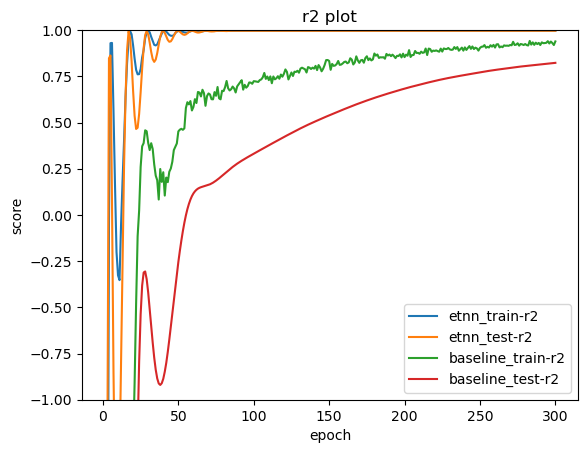

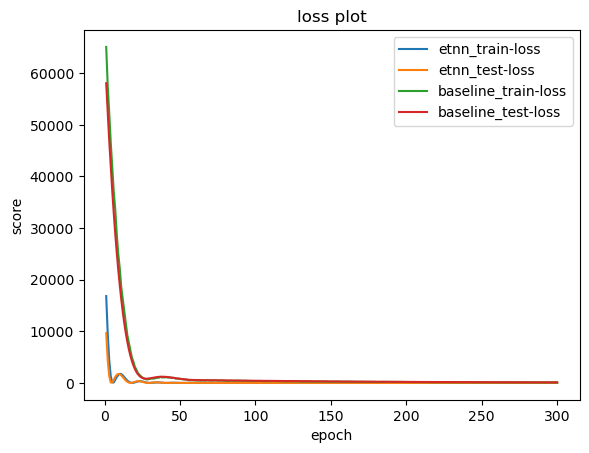

In [11]:
normalized = False
post_normalized = False
size_elem = 10
node_type = "P"
dataset_size = 1000

config_table = pd.read_csv(f"csvs/single-node_t-{node_type}_n-{size_elem}_normalized-{normalized}_post-normalized-{post_normalized}_dataset-size-{dataset_size}.csv")

# sort config storage
config_table = config_table.sort_values(by=['value'], ascending=False)

# iterate over top 3 best configs
for i in range(3):
    # get entry from dataframe
    entry = config_table.iloc[i]

    # print information to console
    print(f"Rank {i+1} parameter configuration: {entry}")

    run(i, entry, size_elem, normalized, node_type, dataset_size)

Rank 1 parameter configuration: Unnamed: 0                                      97
number                                          97
value                                     0.801208
datetime_start          2023-12-21 10:18:22.604179
datetime_complete       2023-12-21 10:18:29.056797
duration                    0 days 00:00:06.452618
params_batcher                                True
params_hidden_dim                              288
params_learning_rate                      0.008696
state                                     COMPLETE
Name: 97, dtype: object
Model params etnn: 223201


100%|██████████| 300/300 [01:46<00:00,  2.82it/s]


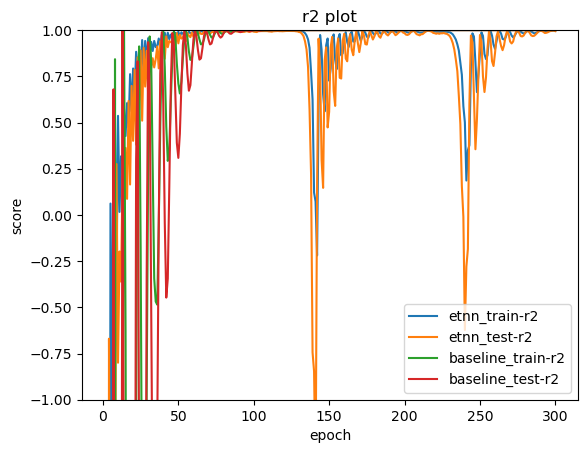

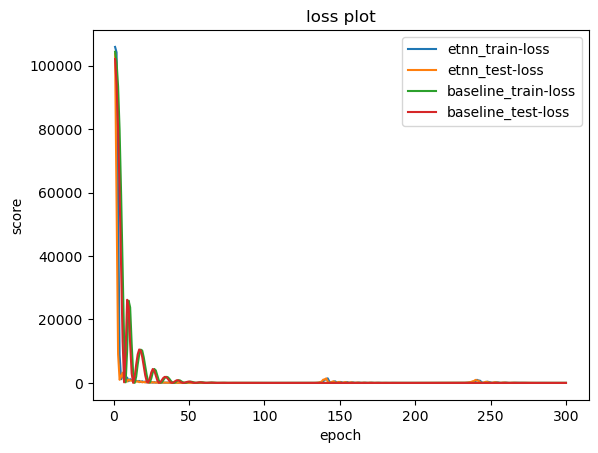

Rank 2 parameter configuration: Unnamed: 0                                      89
number                                          89
value                                     0.497217
datetime_start          2023-12-21 10:17:28.953606
datetime_complete       2023-12-21 10:17:35.637967
duration                    0 days 00:00:06.684361
params_batcher                               False
params_hidden_dim                              304
params_learning_rate                      0.007143
state                                     COMPLETE
Name: 89, dtype: object
Model params etnn: 248369


100%|██████████| 300/300 [01:42<00:00,  2.92it/s]


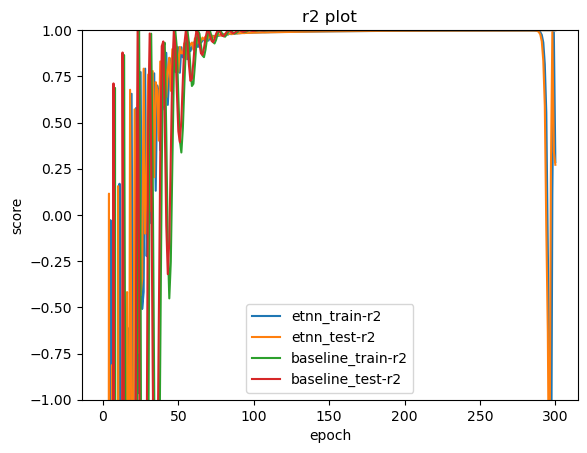

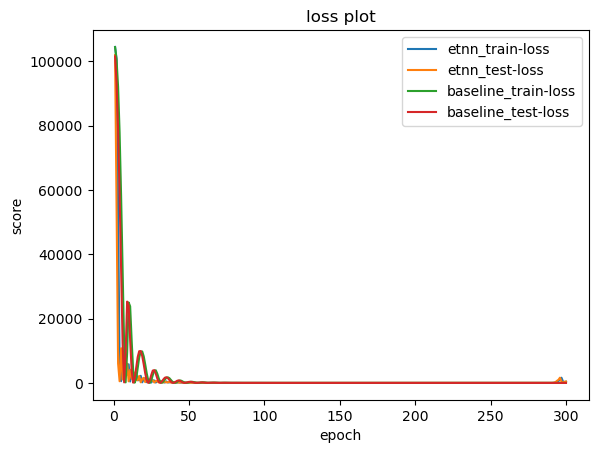

Rank 3 parameter configuration: Unnamed: 0                                      80
number                                          80
value                                     0.479981
datetime_start          2023-12-21 10:16:28.839078
datetime_complete       2023-12-21 10:16:35.503356
duration                    0 days 00:00:06.664278
params_batcher                               False
params_hidden_dim                              304
params_learning_rate                      0.007284
state                                     COMPLETE
Name: 80, dtype: object
Model params etnn: 248369


100%|██████████| 300/300 [01:52<00:00,  2.68it/s]


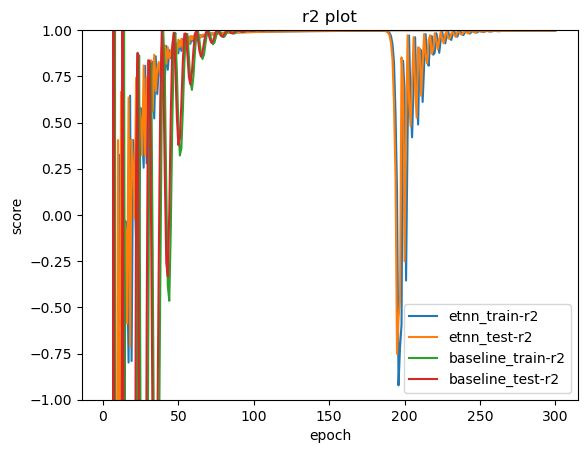

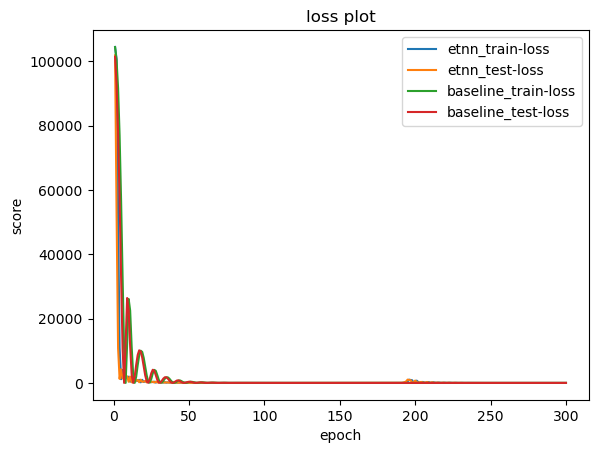

In [12]:
normalized = True
post_normalized = False
size_elem = 10
node_type = "P"
dataset_size = 1000

config_table = pd.read_csv(f"csvs/single-node_t-{node_type}_n-{size_elem}_normalized-{normalized}_post-normalized-{post_normalized}_dataset-size-{dataset_size}.csv")

# sort config storage
config_table = config_table.sort_values(by=['value'], ascending=False)

# iterate over top 3 best configs
for i in range(3):
    # get entry from dataframe
    entry = config_table.iloc[i]

    # print information to console
    print(f"Rank {i+1} parameter configuration: {entry}")

    run(i, entry, size_elem, normalized, node_type, dataset_size)

Rank 1 parameter configuration: Unnamed: 0                                     111
number                                         111
value                                     0.457509
datetime_start          2023-12-21 11:19:03.868232
datetime_complete       2023-12-21 11:19:16.201902
duration                    0 days 00:00:12.333670
params_batcher                               False
params_hidden_dim                              368
params_learning_rate                      0.006622
state                                     COMPLETE
Name: 111, dtype: object
Model params etnn: 362481


100%|██████████| 300/300 [02:53<00:00,  1.73it/s]


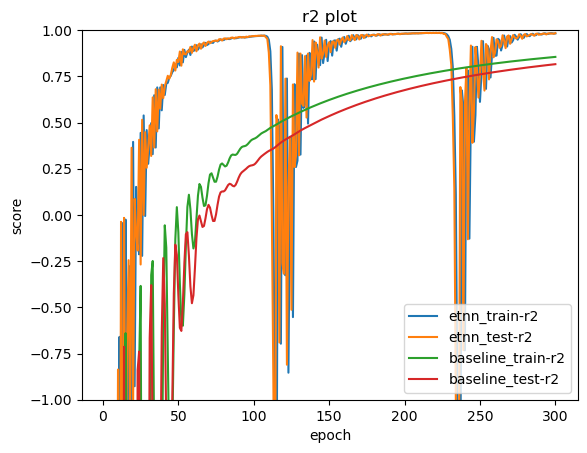

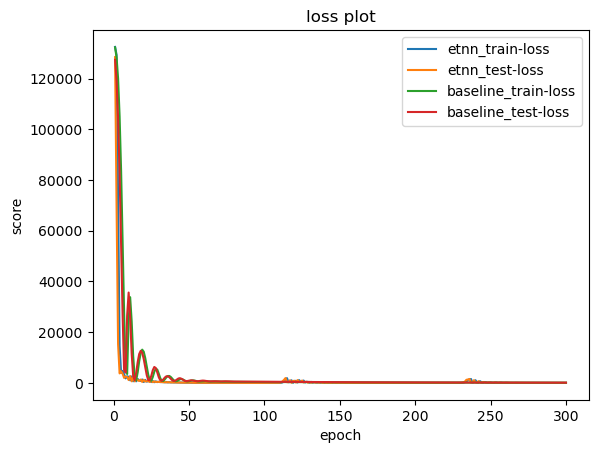

Rank 2 parameter configuration: Unnamed: 0                                      67
number                                          67
value                                     0.197787
datetime_start          2023-12-21 11:10:57.802325
datetime_complete       2023-12-21 11:11:09.048093
duration                    0 days 00:00:11.245768
params_batcher                                True
params_hidden_dim                              336
params_learning_rate                      0.006463
state                                     COMPLETE
Name: 67, dtype: object
Model params etnn: 302737


100%|██████████| 300/300 [02:46<00:00,  1.80it/s]


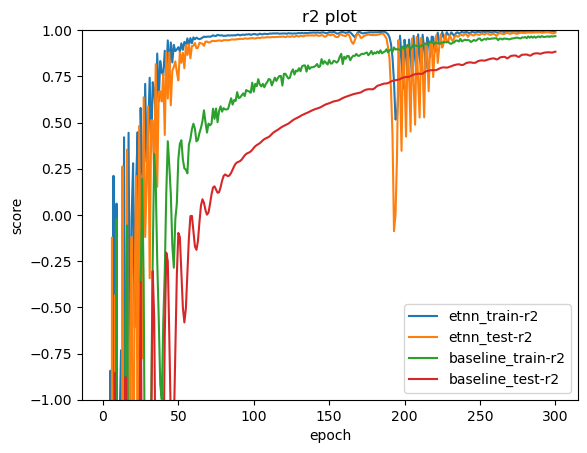

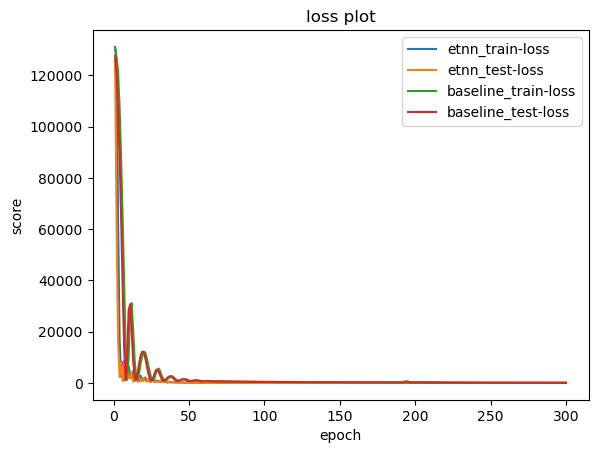

Rank 3 parameter configuration: Unnamed: 0                                      75
number                                          75
value                                    -0.133012
datetime_start          2023-12-21 11:12:24.739205
datetime_complete       2023-12-21 11:12:35.183028
duration                    0 days 00:00:10.443823
params_batcher                               False
params_hidden_dim                              320
params_learning_rate                      0.006459
state                                     COMPLETE
Name: 75, dtype: object
Model params etnn: 274881


100%|██████████| 300/300 [01:55<00:00,  2.59it/s]


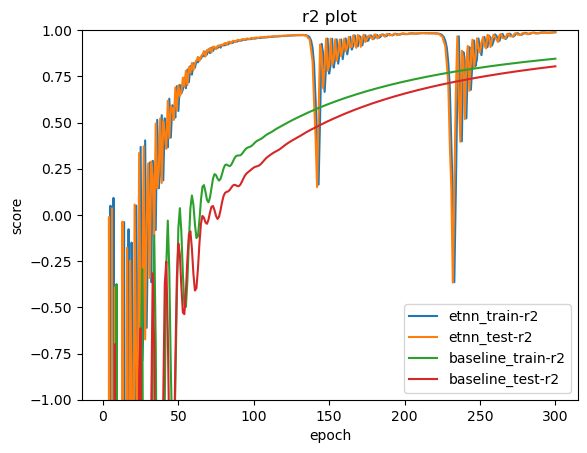

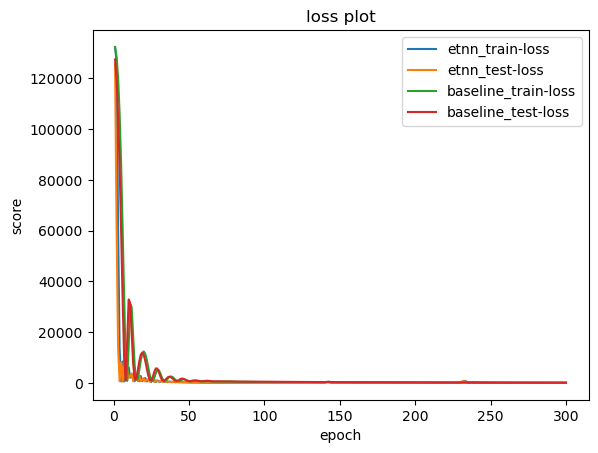

In [13]:
normalized = False
post_normalized = True
size_elem = 10
node_type = "P"
dataset_size = 1000

config_table = pd.read_csv(f"csvs/single-node_t-{node_type}_n-{size_elem}_normalized-{normalized}_post-normalized-{post_normalized}_dataset-size-{dataset_size}.csv")

# sort config storage
config_table = config_table.sort_values(by=['value'], ascending=False)

# iterate over top 3 best configs
for i in range(3):
    # get entry from dataframe
    entry = config_table.iloc[i]

    # print information to console
    print(f"Rank {i+1} parameter configuration: {entry}")

    run(i, entry, size_elem, normalized, node_type, dataset_size)